In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import warnings 
warnings.filterwarnings('ignore')

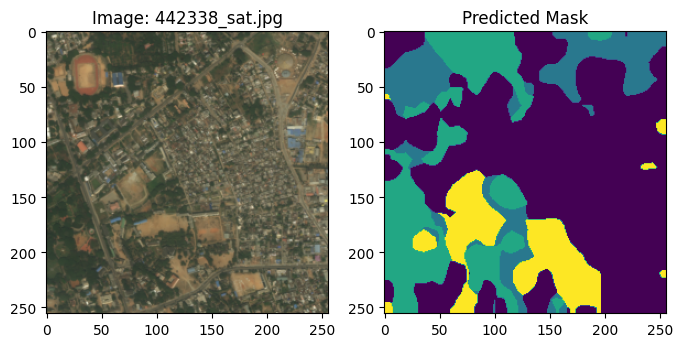

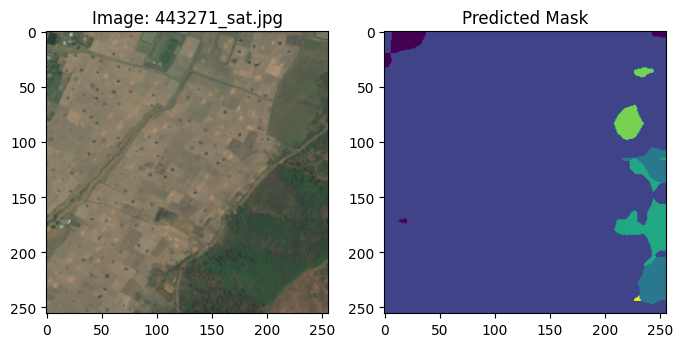

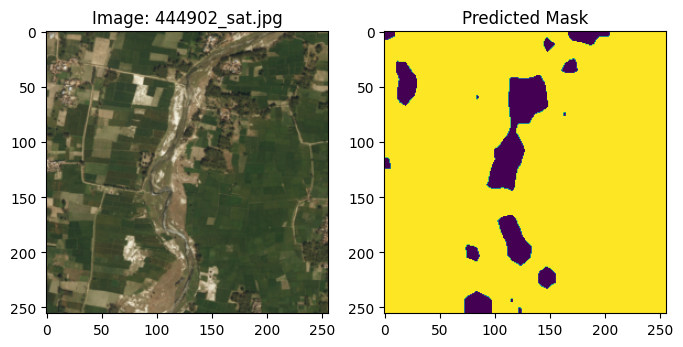

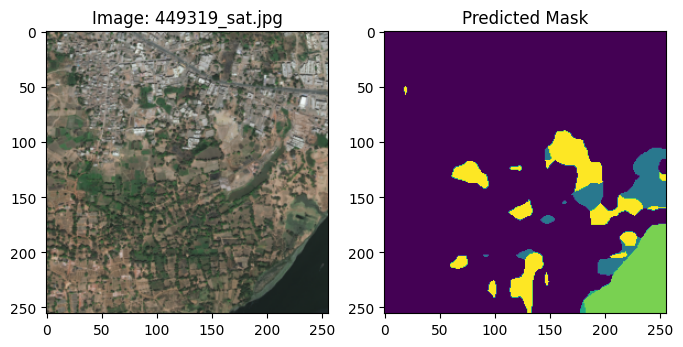

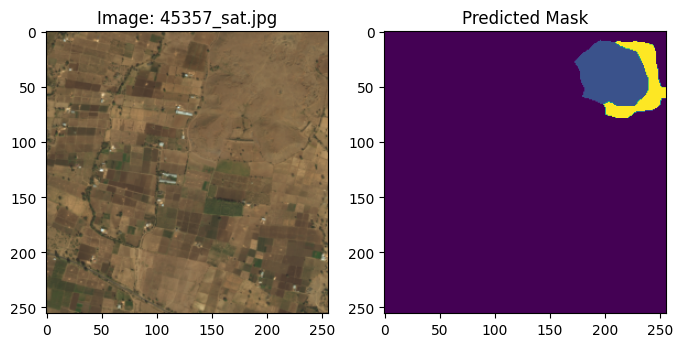

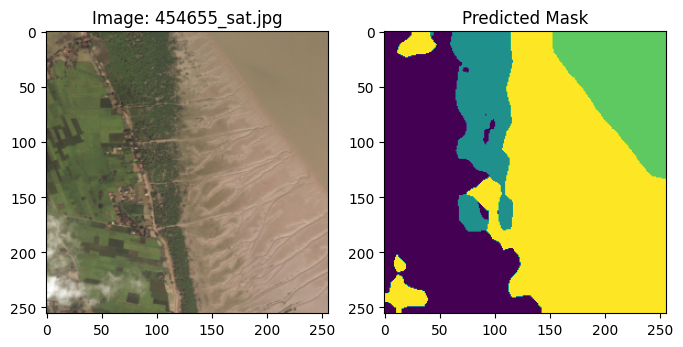

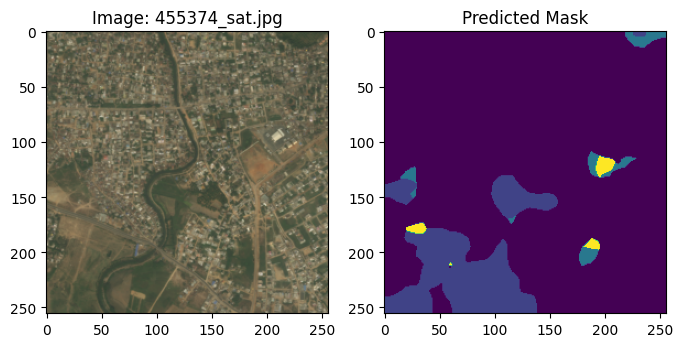

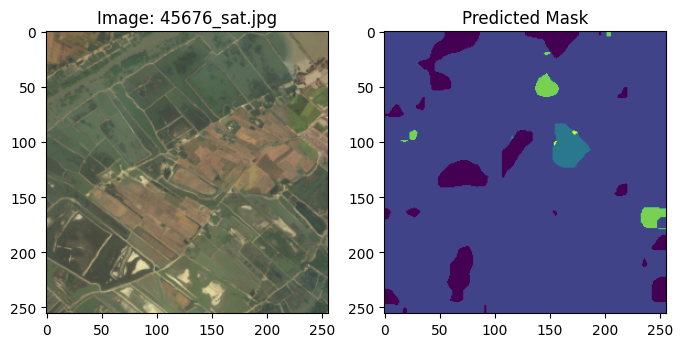

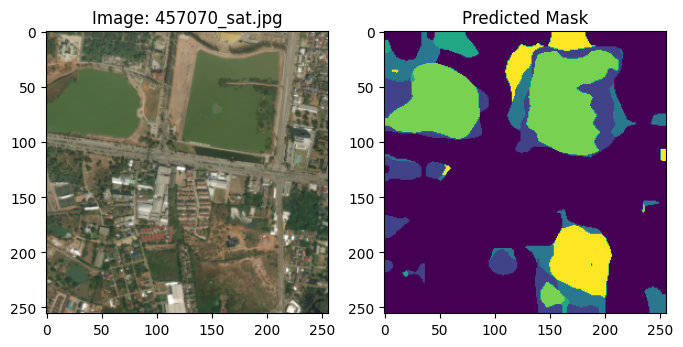

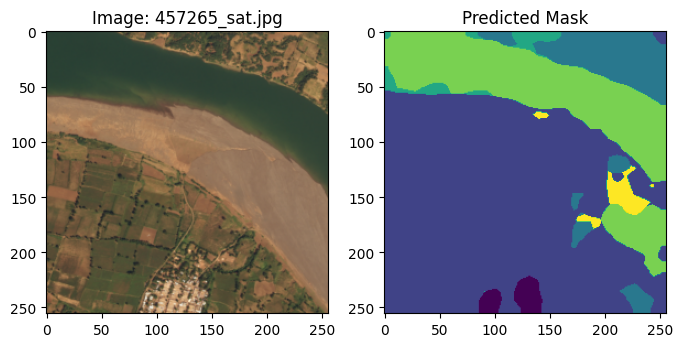

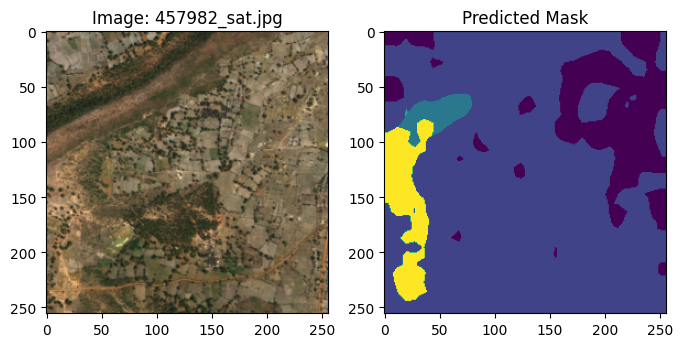

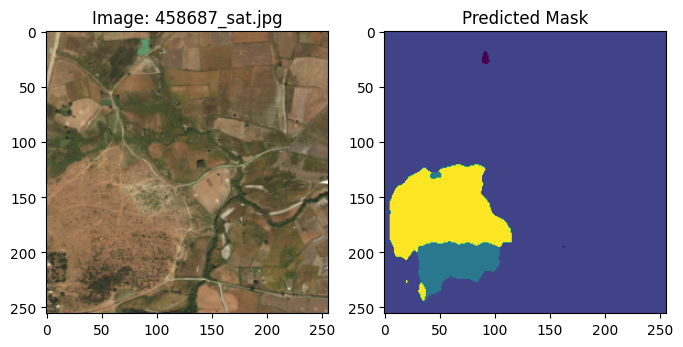

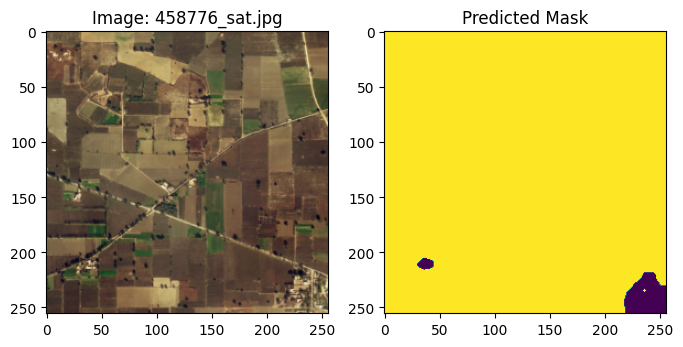

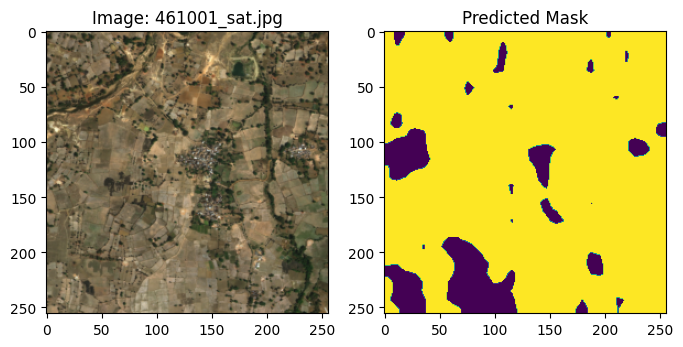

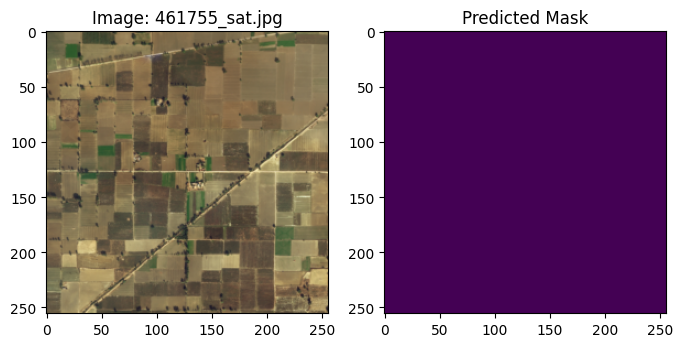

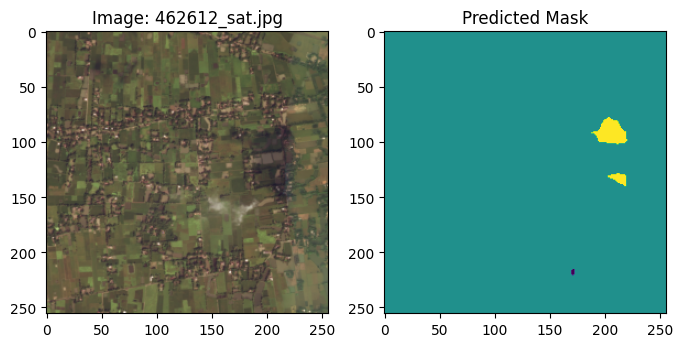

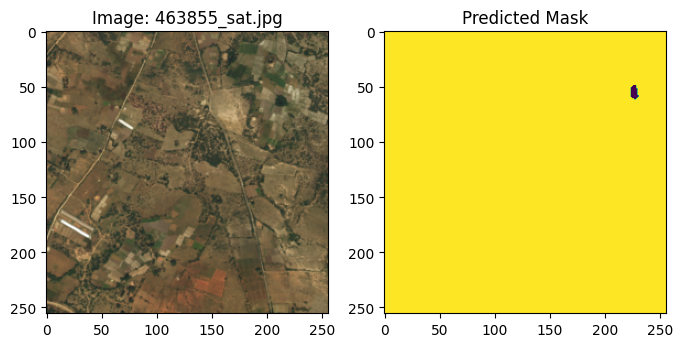

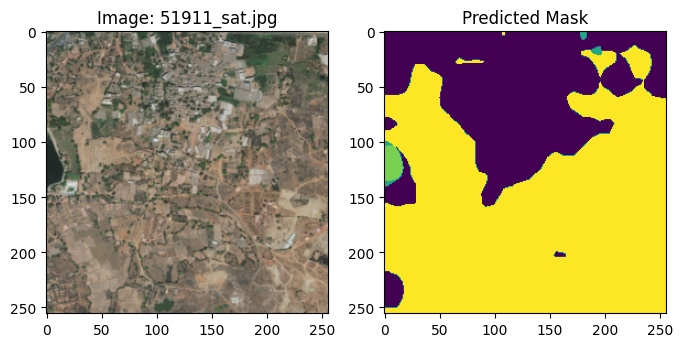

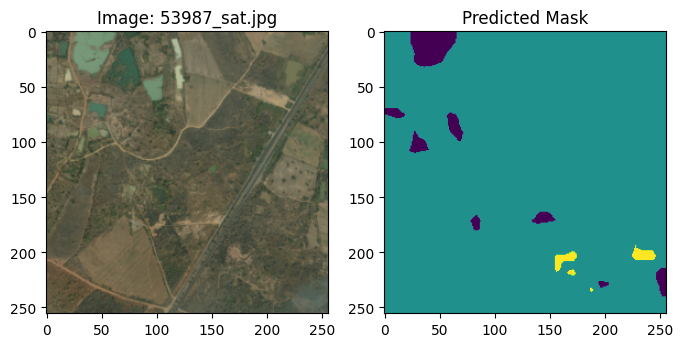

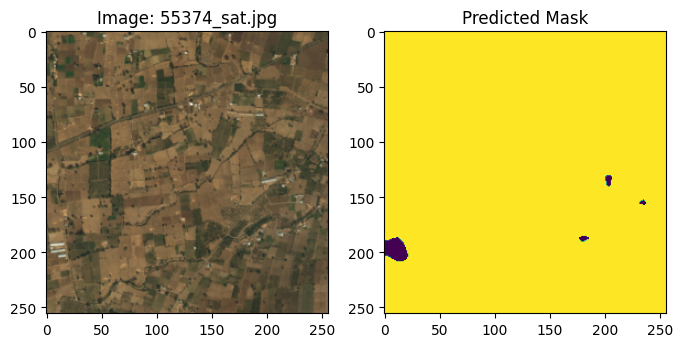

In [25]:
model = torch.load('trained_landcover_model_2.pth')

# Step 1: Update the Dataset class to load test images and optionally ground truth labels
class LandcoverTestDataset(Dataset):
    def __init__(self, data_dir, transform=None, has_labels=False):
        self.data_dir = data_dir
        self.transform = transform
        self.image_list = [f for f in os.listdir(data_dir) if '_sat' in f]
        self.has_labels = has_labels

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Get the satellite image
        image_name = self.image_list[idx]
        image_path = os.path.join(self.data_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            # Load the corresponding mask if ground truth labels are available
            mask_name = image_name.replace('_sat', '_mask').replace('.jpg', '.png')
            mask_path = os.path.join(self.data_dir, mask_name)
            label = Image.open(mask_path).convert('RGB')
            label = label.resize((256, 256), Image.NEAREST)
            label = self.rgb_to_class_indices(np.array(label))
            label = torch.tensor(label, dtype=torch.long)
            return image, image_name, label
        
        return image, image_name

    def rgb_to_class_indices(self, rgb_mask):
        """Convert an RGB mask to class indices based on predefined colors."""
        rgb_to_class = {
            (0, 255, 255): 0,       # Urban Land
            (255, 255, 0): 1,       # Agriculture Land
            (255, 0, 255): 2,       # Rangeland
            (0, 255, 0): 3,         # Forest Land
            (0, 0, 255): 4,         # Water
            (255, 255, 255): 5,     # Barren Land
            (0, 0, 0): 6            # Unknown
        }
        class_mask = np.zeros((rgb_mask.shape[0], rgb_mask.shape[1]), dtype=np.uint8)
        for rgb, class_index in rgb_to_class.items():
            match = np.all(rgb_mask == rgb, axis=-1)
            class_mask[match] = class_index
        return class_mask

# Step 2: Data preprocessing (resize images and convert to tensors)
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define path for the test directory containing satellite images
test_dir = 'C:\\Users\\ADMIN\\Documents\\semi_supervised learning\\land-cover-classification-dataset\\valid'
has_labels = True  # Set this to True if ground truth labels are available for testing

# Create the test dataset and dataloader
test_dataset = LandcoverTestDataset(test_dir, transform=image_transform, has_labels=has_labels)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

evaluation_metric = []
# Step 3: Function to compute IoU, Precision, Recall, F1-Score
def compute_metrics(pred, target, num_classes):
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()
    iou, precision, recall, f1 = [], [], [], []

    for cls in range(num_classes):
        pred_cls = (pred == cls).astype(np.uint8)
        target_cls = (target == cls).astype(np.uint8)
        iou.append(jaccard_score(target_cls.flatten(), pred_cls.flatten(), average='binary'))
        precision.append(precision_score(target_cls.flatten(), pred_cls.flatten(), average='binary'))
        recall.append(recall_score(target_cls.flatten(), pred_cls.flatten(), average='binary'))
        f1.append(f1_score(target_cls.flatten(), pred_cls.flatten(), average='binary'))

    return np.mean(iou), np.mean(precision), np.mean(recall), np.mean(f1)

# Step 4: Modified function to test the model on satellite images with evaluation
def test_on_satellite_images(model, dataloader, num_classes=7, visualize=True, n_examples=4):
    model.eval()
    iou_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            if has_labels:
                images, image_names, labels = data
                labels = labels
            else:
                images, image_names = data

            images = images
            outputs = model(images)['out']
            predictions = torch.argmax(outputs, dim=1)

            # Compute metrics if ground truth is available
            if has_labels:
                iou, precision, recall, f1 = compute_metrics(predictions, labels, num_classes)
                iou_scores.append(iou)
                precision_scores.append(precision)
                recall_scores.append(recall)
                f1_scores.append(f1)

            # Visualize some test images and predictions
            if visualize and batch_idx < n_examples:
                visualize_prediction_on_satellite(images, predictions, image_names)

    # Average the metrics across the dataset
    if has_labels:
        avg_iou = np.mean(iou_scores)
        avg_precision = np.mean(precision_scores)
        avg_recall = np.mean(recall_scores)
        avg_f1 = np.mean(f1_scores)
        evaluation_metric.append(f"Average IoU: {avg_iou:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-Score: {avg_f1:.4f}")

# Step 5: Visualization function for satellite predictions
def visualize_prediction_on_satellite(images, predictions, image_names):
    for i in range(len(images)):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        pred = predictions[i].cpu().numpy()

        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(img)
        axs[0].set_title(f"Image: {image_names[i]}")
        axs[1].imshow(pred)
        axs[1].set_title("Predicted Mask")
        plt.show()

# Step 6: Run the testing function
test_on_satellite_images(model, test_dataloader, num_classes=7, visualize=True, n_examples=5)

In [26]:
evaluation_metric

['Average IoU: 0.2646, Precision: 0.3697, Recall: 0.3293, F1-Score: 0.3207']